# The Kuramoto model on GPU

---
Modifing the model, adding noise, changing initial states and other parameters is strightforward and just need to modify Python functions.The  parallelizarion happen along the number of simulations `ns`.

Author: [A. Ziaeemehr](https://github.com/Ziaeemehr)

<a href="https://colab.research.google.com/github/Ziaeemehr/workshop_hpcpy/blob/main/notebooks/cupy/km_cupy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   File-> save a copy in Drive
*   From Runtime, choose `Change runtime type`
*   select `GPU`


In [16]:
# only for colab
# !pip install chainer

In [15]:
# only for colab
# import chainer
# chainer.print_runtime_info()

In [1]:
import cupy as cp

def get_gpu_info():
    device_count = cp.cuda.runtime.getDeviceCount()
    print(f"Number of GPUs available: {device_count}")
    for i in range(device_count):
        props = cp.cuda.runtime.getDeviceProperties(i)
        print(f"\nGPU {i}: {props['name'].decode('utf-8')}")
        print(f"  Compute Capability: {props['major']}.{props['minor']}")
        print(f"  Total Memory: {props['totalGlobalMem'] / 1024**3:.2f} GB")
        print(f"  Multiprocessors: {props['multiProcessorCount']}")
        print(f"  Max Threads Per Block: {props['maxThreadsPerBlock']}")
        print(f"  Clock Rate: {props['clockRate'] / 1000:.2f} MHz")

get_gpu_info()


Number of GPUs available: 1

GPU 0: NVIDIA RTX A5000
  Compute Capability: 8.6
  Total Memory: 23.68 GB
  Multiprocessors: 64
  Max Threads Per Block: 1024
  Clock Rate: 1695.00 MHz


In [2]:
import tqdm
import cupy as cp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
cp.random.seed(2)

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

def whereis(x):
    print(x.device_buffer.device())

In [4]:
def get_module(engine="gpu"):
    '''
    to switch engine between gpu and cpu
    '''
    if engine == "gpu":
        return cp.get_array_module(cp.array([1]))
    else:
        return np


In [5]:
cp.random.seed(2)
np.random.seed(2)

nn = 100             # number of nodes
ns = 120             # number of simulations
T = 1000.0           # time
TC = 500.0           # time to cut from the simulations (transient behavior)
dt = 0.05
engine = "gpu"       # "cpu" or "gpu"
xp = get_module(engine)    # xp use numpy or cupy depending on the selected engine
t = xp.arange(0.0, T, dt)
K = xp.linspace(0, 1.0, ns) # coupling with the same length of ns
SC = nx.to_numpy_array(nx.gnp_random_graph(nn, p=0.5, seed=2), dtype=int)  # structural connectivity
SC = xp.array(SC.reshape(SC.shape+(1,)))                  # just reshaping of SC
x = xp.random.uniform(0, 2*np.pi, size=(nn, ns))          # initial state
omega = xp.random.normal(0, 1.0, size=(nn, ns))           # initial omega
x.shape, SC.shape, omega.shape, K.shape, (K * x).shape

((100, 120), (100, 100, 1), (100, 120), (120,), (100, 120))

In [6]:
def f_sys(x, omega, K, SC):
    return omega + K * xp.sum(SC * xp.sin(x - x[:,None]), axis=1)

def euler_step(x, omega, K, SC, dt):
    return x + dt * f_sys(x, omega, K, SC)

def runge_kutta_step(x, omega, K, SC, dt):
    k1 = f_sys(x, omega, K, SC)
    k2 = f_sys(x + dt * k1 / 2, omega, K, SC)
    k3 = f_sys(x + dt * k2 / 2, omega, K, SC)
    k4 = f_sys(x + dt * k3, omega, K, SC)
    return x + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6

def calc_r(theta):
    nt, nn = theta.shape
    r = np.zeros(nt)
    for i in range(nt):
        r[i] = abs(np.sum(np.exp(1j * theta[i, :]))) / nn
    return r

def calc_r_cupy(theta):
    """
    Calculate the order parameter using CuPy for faster computation on the GPU.

    Parameters:
    - theta (cupy.ndarray): A 2D array of shape (nt, nn), representing phases.

    Returns:
    - cupy.ndarray: A 1D array of length nt, representing the order parameters.
    """
    nt, nn = theta.shape
    # Calculate the sum of exp(1j * theta) for each row
    exp_sum = cp.sum(cp.exp(1j * theta), axis=1)
    # Calculate the absolute value and normalize
    r = cp.abs(exp_sum) / nn
    return r

In [7]:
# SC.shape, SC.shape+(1,)
# SC.reshape(SC.shape+(1,)).shape

In [8]:
xs = [x.get() if engine=="gpu" else x]

for it in tqdm.tqdm(range(1, t.shape[0])):
  t = it * dt
  # x = euler_step(x, omega, K, SC, dt)
  x = runge_kutta_step(x, omega, K, SC, dt)

  if (t > TC) and (it % 1 == 0): # drop TC and store each n step
      if engine == "gpu":
          xs.append(x.get())
      else:
          xs.append(x)



100%|██████████| 19999/19999 [00:26<00:00, 768.69it/s]


In [9]:
xs = np.asarray(xs)
xs.shape # (ntimes, nnnodes, nsimulations)

(10000, 100, 120)

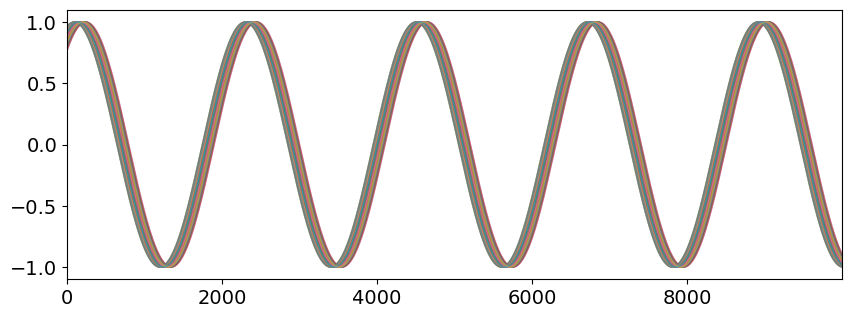

In [10]:
plt.figure(figsize=(10, 3.5))
plt.plot(np.sin(xs[:, :, ns-1]), lw=1, alpha=0.5)
# plt.xlim(100, 1500)
plt.show()

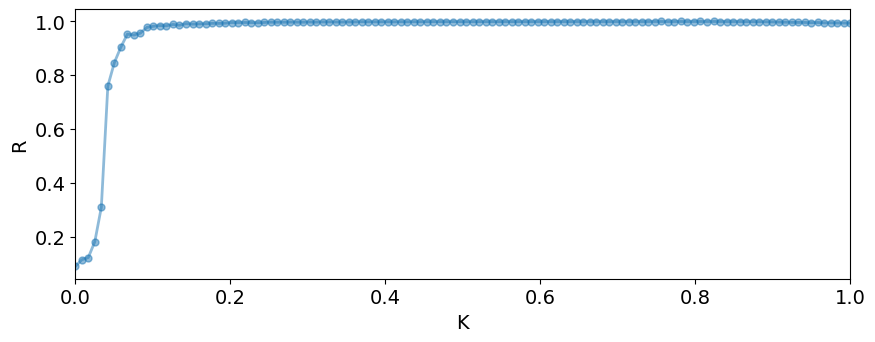

In [11]:
R = np.zeros(ns)
for i in range(ns):
    theta = xs[:, :, i]
    if engine == "gpu":
        r = calc_r_cupy(cp.array(theta))
        R[i] = cp.mean(r).get()
    else:
        r = calc_r(theta)
        R[i] = np.mean(r)

plt.figure(figsize=(10, 3.5))
plt.plot(K.get().squeeze(), R, marker="o", lw=2, alpha=0.5, ms=5);
plt.xlabel("K")
plt.ylabel("R")
plt.margins(x=0)

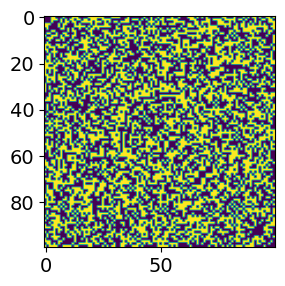

In [23]:
plt.figure(figsize=(3, 3))
plt.imshow(SC[:,:,0].get());

In [ ]:
SC[:,:,0].get().max(), SC[:,:,0].get().min()

(1, 0)